In [1]:
%matplotlib inline
from sklearn import linear_model
import scipy.stats
import os
import shutil
import re
import numpy as np
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import matplotlib.pyplot as plt
from Bio import SeqIO
from src import contig_stats
sns.set_style("whitegrid")

In [19]:
path = "/media/NGS/Sequence/Mycobacterium_tuberculosis/NCBI_complete"

In [20]:
def run(args):
    fasta, file = args
    id = re.sub(r".fna$", "", file)
    n25, n50, n75, m, c = contig_stats.stats(list(SeqIO.parse(fasta, "fasta")))
    return id, n25, n50, n75, m, c

In [21]:
args = ((os.path.join(path, file), file) for file in os.listdir(path))
data = list(ProcessPoolExecutor(25).map(run, args, chunksize=64))

In [22]:
table = pd.DataFrame(data, columns=["id", "N25", "N50", "N75", "total_length", "counts"])
table.shape

(184, 6)

In [23]:
identify = pd.read_csv('/media/NGS/Sequence/Mycobacterium_tuberculosis/Identify.csv', index_col=0)
identify = identify[identify['Species'] == 'Mycobacterium tuberculosis']

table = pd.merge(table, identify, left_on='id', right_index=True)
table.head()

,id,N25,N50,N75,total_length,counts,Query_Coverage,Template_Coverage,Species
0,GCA_000738445.1,4411507,4411507,4411507,4411507,1,100.0,100.0,Mycobacterium tuberculosis
1,GCA_002886945.1,4411443,4411443,4411443,4411443,1,100.0,100.0,Mycobacterium tuberculosis
2,GCA_002887065.1,4411469,4411469,4411469,4411469,1,100.0,100.0,Mycobacterium tuberculosis
3,GCA_002448095.1,4411314,4411314,4411314,4411314,1,100.0,100.0,Mycobacterium tuberculosis
4,GCA_000154605.2,4399120,4399120,4399120,4399120,1,100.0,100.0,Mycobacterium tuberculosis


# Combine metadata selection

In [24]:
metafile = "/media/NGS/Sequence/Mycobacterium_tuberculosis/METADATA.csv"
meta = pd.read_csv(metafile)
meta = meta[meta["GC%"] != "-"]
meta["GC%"] = meta['GC%'].astype(float)

In [30]:
curated = pd.merge(table, meta, left_index=True, left_on='id', right_on="Assembly")
curated.shape

(184, 30)

In [26]:
def fence(df, subset):
    std = curated[subset].std()
    mean = curated[subset].mean()
    return (curated[subset]>(mean - 2*std))&(curated[subset]<(mean + 2*std))

In [31]:
curated['outlier'] = ~(fence(curated, 'Size (Mb)'))
curated[~curated['outlier']].shape

(171, 31)

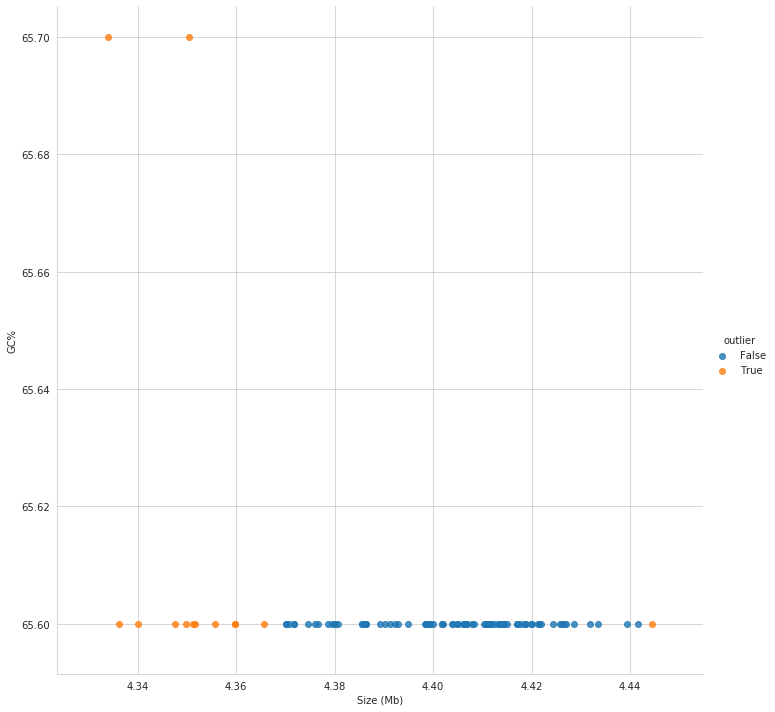

In [32]:
sns.lmplot(data=curated, x="Size (Mb)", y="GC%", fit_reg=False, size=10, hue='outlier')

# N25, N50, N75

Text(0, 0.5, 'number')

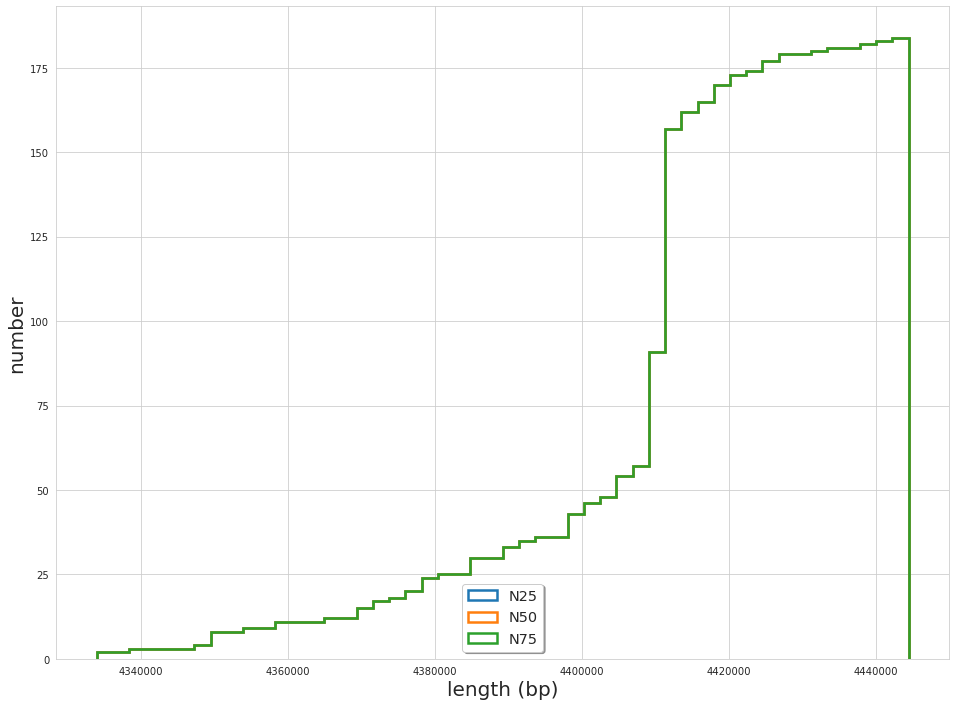

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(table["N25"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(table["N50"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(table["N75"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='lower center', shadow=True, fontsize='x-large')
plt.xlabel("length (bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

Text(0, 0.5, 'number')

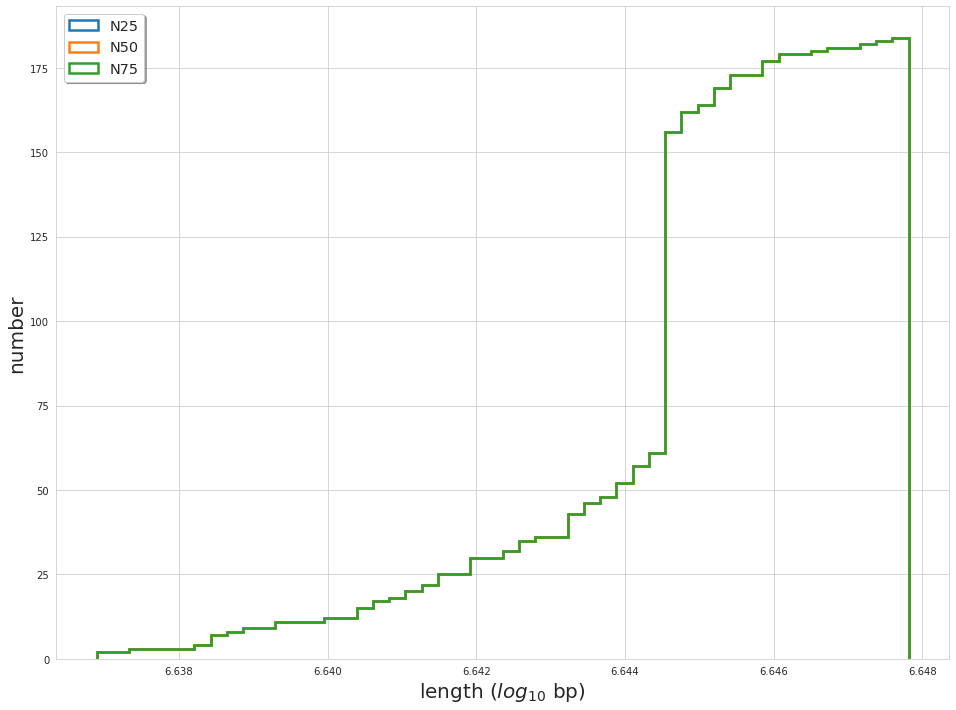

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(np.log10(table["N25"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(np.log10(table["N50"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(np.log10(table["N75"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel("length ($log_{10}$ bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

# Contigs count

Text(0.5, 1.0, 'Genome contig number distribution')

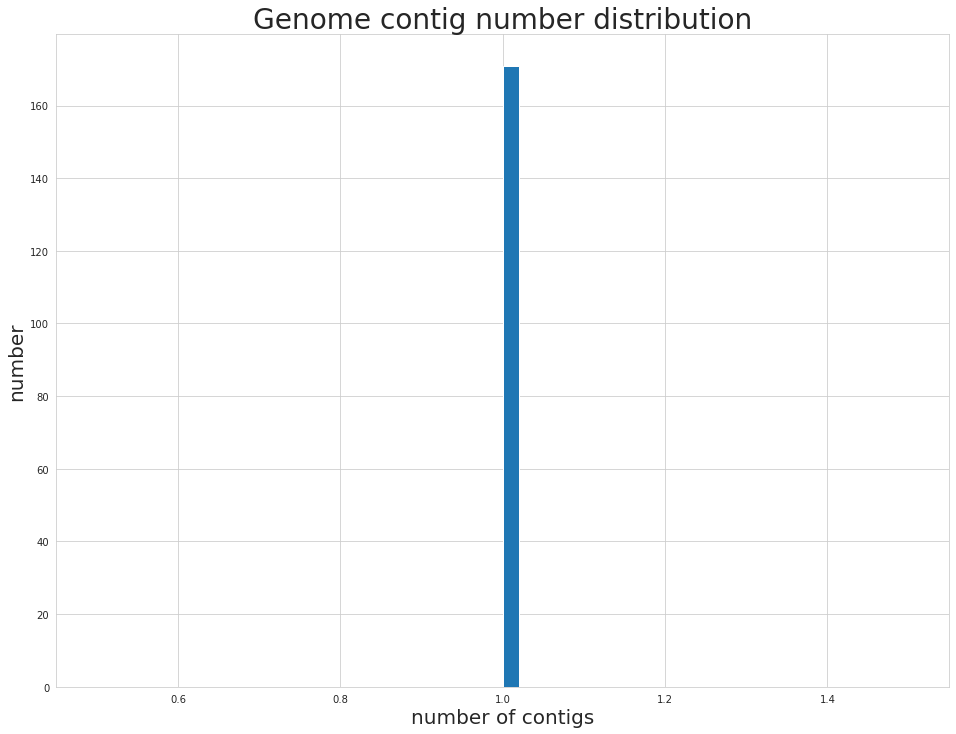

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["counts"][~curated['outlier']], bins=50)
plt.xlabel("number of contigs", fontsize=20)
plt.ylabel("number", fontsize=20)
plt.title("Genome contig number distribution", fontsize=28)

# selection of clean dataset

In [36]:
for i in curated['id']:
    shutil.copy(os.path.join(path, i+'.fna'), '/media/NGS/Sequence/Mycobacterium_tuberculosis/NCBI_clean')